# Playground for plotting redfactoring.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from geodatasets import get_path
from matplotlib.collections import PatchCollection

import geopandas as gpd

Use Guerry data. It has categorical (Region) as well as planty of continuous. Has Polygon and MultiPolygon geometry.

In [2]:
df = gpd.read_file(get_path("geoda guerry"))

## PolygonPatch working on MultiPolygons

Try getting PolygonPatch for a MultiPolygon so we don't need to explode.

In [5]:
def _PolygonPatch(polygon, **kwargs):
    """Construct a matplotlib patch from a (Multi)Polygon geometry.

    The `kwargs` are those supported by the matplotlib.patches.PathPatch class
    constructor. Returns an instance of matplotlib.patches.PathPatch.

    To ensure proper rendering on the matplotlib side, winding order of individual
    rings needs to be normalized as the order is what matplotlib uses to determine
    if a Path represents a patch or a hole.

    Example (using Shapely Point and a matplotlib axes)::

        b = shapely.geometry.Point(0, 0).buffer(1.0)
        patch = _PolygonPatch(b, fc='blue', ec='blue', alpha=0.5)
        ax.add_patch(patch)

    GeoPandas originally relied on the descartes package by Sean Gillies
    (BSD license, https://pypi.org/project/descartes) for PolygonPatch, but
    this dependency was removed in favor of the below matplotlib code.
    """
    from matplotlib.patches import PathPatch
    from matplotlib.path import Path

    if polygon.geom_type == "Polygon":
        path = Path.make_compound_path(
            Path(np.asarray(polygon.exterior.coords)[:, :2], closed=True),
            *[
                Path(np.asarray(ring.coords)[:, :2], closed=True)
                for ring in polygon.interiors
            ],
        )
    else:
        paths = []
        for part in polygon.geoms:
            # exteriors
            paths.append(Path(np.asarray(part.exterior.coords)[:, :2], closed=True))
            # interiors
            for ring in part.interiors:
                paths.append(Path(np.asarray(ring.coords)[:, :2], closed=True))
        path = Path.make_compound_path(*paths)

    return PathPatch(path, **kwargs)

## Collections that are understood by Legend

PatchCollection is not directly supported by a legend.

Subclass.

In [9]:
class GeoPandasPolyCollection(PatchCollection): ...

Assign default handler to our custom subclass.

In [10]:
from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerPolyCollection

Legend.update_default_handler_map({GeoPandasPolyCollection: HandlerPolyCollection()})

Test

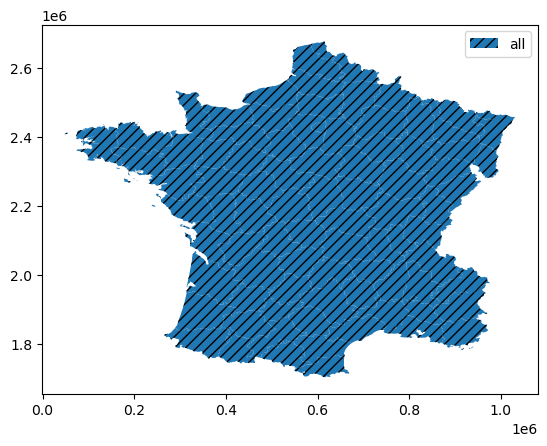

In [13]:
f, ax = plt.subplots()
collection = GeoPandasPolyCollection(
    [_PolygonPatch(poly) for poly in df.geometry], label="all", hatch="///"
)
ax.add_collection(collection)
ax.autoscale_view()
ax.legend()

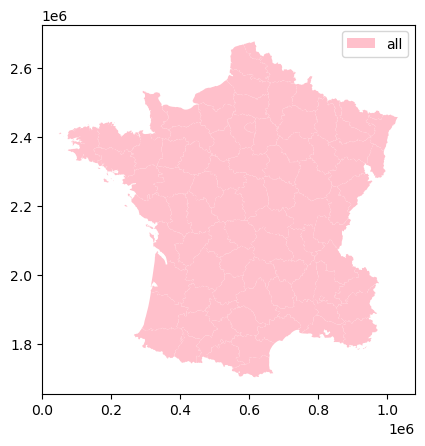

In [3]:
df.plot(label="all", color="pink")
plt.legend()